In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb as db
from scipy.stats import zscore

In [21]:
Cupid_file = pd.read_excel('C:\MyCode\Data\Kaggle\Profile_data.xlsx', sheet_name='okcupid_profiles')

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\admin\AppData\Local\Temp\ipykernel_21712\2232489720.py:1: SyntaxWarning: invalid escape sequence '\M'
  Cupid_file = pd.read_excel('C:\MyCode\Data\Kaggle\Profile_data.xlsx', sheet_name='okcupid_profiles')


In [22]:
# Drop columns with all NaN values
Cupid_file_cleaned = Cupid_file.dropna(axis=1, how='all')

# Drop duplicate rows
Cupid_file_cleaned = Cupid_file_cleaned.drop_duplicates()

# Removing columns with more than 80% missing values
threshold = 0.8
missing_ratio = Cupid_file_cleaned.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > threshold].index
Cupid_file_cleaned = Cupid_file_cleaned.drop(columns=cols_to_drop)

# Optionally, fill remaining NaN values with appropriate values (e.g., empty string for object columns)
for col in Cupid_file_cleaned.select_dtypes(include='object').columns:
    Cupid_file_cleaned[col] = Cupid_file_cleaned[col].fillna('')

# Reset index
Cupid_file_cleaned = Cupid_file_cleaned.reset_index(drop=True)


In [23]:
Cupid_file_cleaned.select_dtypes(include='object').columns

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'pets', 'religion', 'sign',
       'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4',
       'essay5', 'essay6', 'essay7', 'essay8', 'essay9'],
      dtype='object')

In [24]:
# Removing 1 unwanted row & performing EDA
Cupid_file_cleaned = Cupid_file_cleaned[Cupid_file_cleaned['sex'] != ' strength trainer/power lifter with brains and heart']
print("Shape of dataset:", Cupid_file_cleaned.shape)

print("\nInfo:")
print(Cupid_file_cleaned.info())


print("\nDescribe (numeric):")
print(Cupid_file_cleaned.describe())
  
# Summary statistics for object columns
print("\nDescribe (object):")
print(Cupid_file_cleaned.describe(include='object'))

# Count of missing values per column (top 10)
print("\nMissing values (top 10):")
print(Cupid_file_cleaned.isnull().sum().sort_values(ascending=False).head(10))

# Distribution of target-like columns (if any)
print("\nValue counts for 'sex':")
print(Cupid_file_cleaned['sex'].value_counts())

print("\nValue counts for 'status':")
print(Cupid_file_cleaned['status'].value_counts())

print("\nValue counts for 'orientation':")
print(Cupid_file_cleaned['orientation'].value_counts())




Shape of dataset: (59946, 31)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 59946 entries, 0 to 59946
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          59946 non-null  object
 1   status       59946 non-null  object
 2   sex          59946 non-null  object
 3   orientation  59946 non-null  object
 4   body_type    59946 non-null  object
 5   diet         59946 non-null  object
 6   drinks       59946 non-null  object
 7   drugs        59946 non-null  object
 8   education    59946 non-null  object
 9   ethnicity    59946 non-null  object
 10  height       59946 non-null  object
 11  income       59946 non-null  object
 12  job          59946 non-null  object
 13  last_online  59946 non-null  object
 14  location     59946 non-null  object
 15  offspring    59946 non-null  object
 16  pets         59946 non-null  object
 17  religion     59946 non-null  object
 18  sign         59946 non-null  objec

In [25]:
# Finding correlations between columns
numeric_cols = Cupid_file_cleaned.select_dtypes(include=[np.number]).columns

if len(numeric_cols) == 0:
    # Try to encode categorical columns that can be meaningfully converted
    # For simplicity, encode 'sex', 'orientation', 'status', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'smokes' as category codes
    encode_cols = ['sex', 'orientation', 'status', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity', 'job', 'smokes']
    Cupid_encoded = Cupid_file_cleaned.copy()
    for col in encode_cols:
        Cupid_encoded[col] = Cupid_encoded[col].astype('category').cat.codes
    # Add 'age', 'height', 'income' if they are convertible to numeric
    # Only convert columns that exist and should be numeric
    for col in ['age', 'height', 'income']:
        if col in Cupid_encoded.columns:
            Cupid_encoded[col] = pd.to_numeric(Cupid_encoded[col], errors='coerce')
    # Compute correlation matrix using only numeric columns
    corr_matrix = Cupid_encoded.select_dtypes(include=[np.number]).corr()
else:
    corr_matrix = Cupid_file_cleaned[numeric_cols].corr()

print(corr_matrix)

                  age    status       sex  orientation  body_type      diet  \
age          1.000000 -0.016353 -0.041481     0.062062  -0.024695 -0.066094   
status      -0.016353  1.000000 -0.005427     0.184207  -0.003947 -0.009627   
sex         -0.041481 -0.005427  1.000000     0.076664  -0.077528 -0.015892   
orientation  0.062062  0.184207  0.076664     1.000000  -0.028797 -0.026757   
body_type   -0.024695 -0.003947 -0.077528    -0.028797   1.000000  0.083375   
diet        -0.066094 -0.009627 -0.015892    -0.026757   0.083375  1.000000   
drinks      -0.005673  0.012056 -0.030084     0.025558   0.007875  0.024208   
drugs       -0.061627 -0.074184  0.026152    -0.076810   0.040695  0.045576   
education   -0.184449  0.002079 -0.028758    -0.043762   0.022208  0.069116   
ethnicity    0.121535 -0.019887  0.002320    -0.004993   0.033694  0.064685   
height      -0.022262 -0.017163  0.655448     0.060391  -0.039648  0.006450   
income      -0.001004 -0.016817  0.074601     0.0033

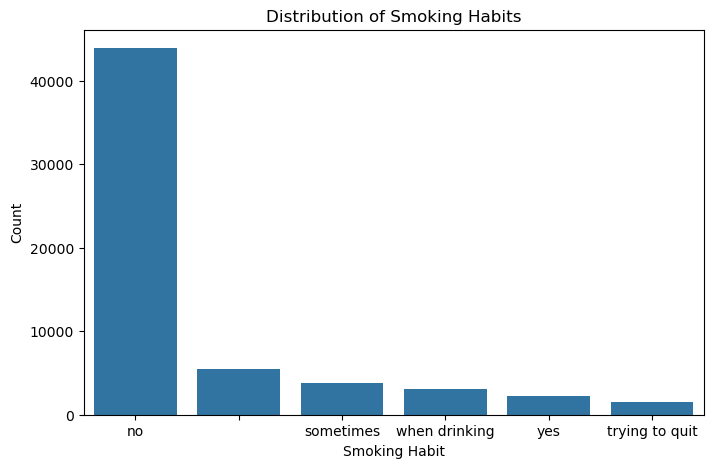

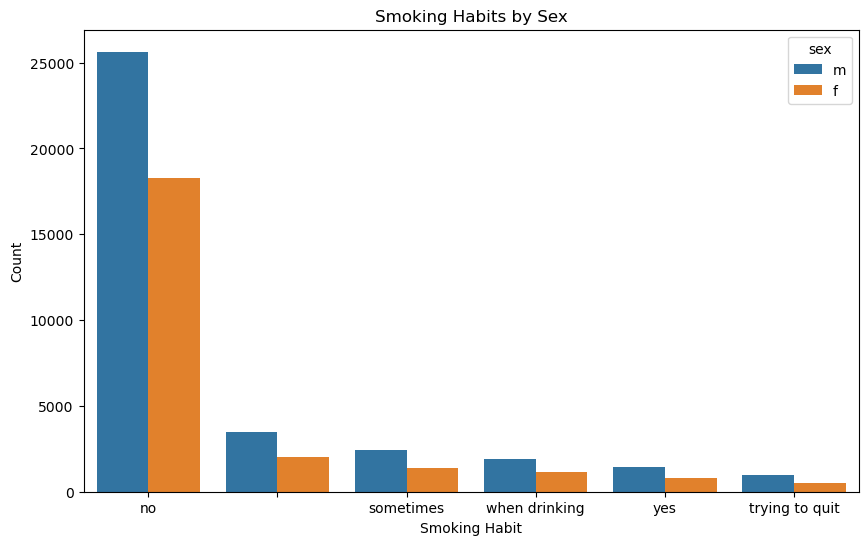

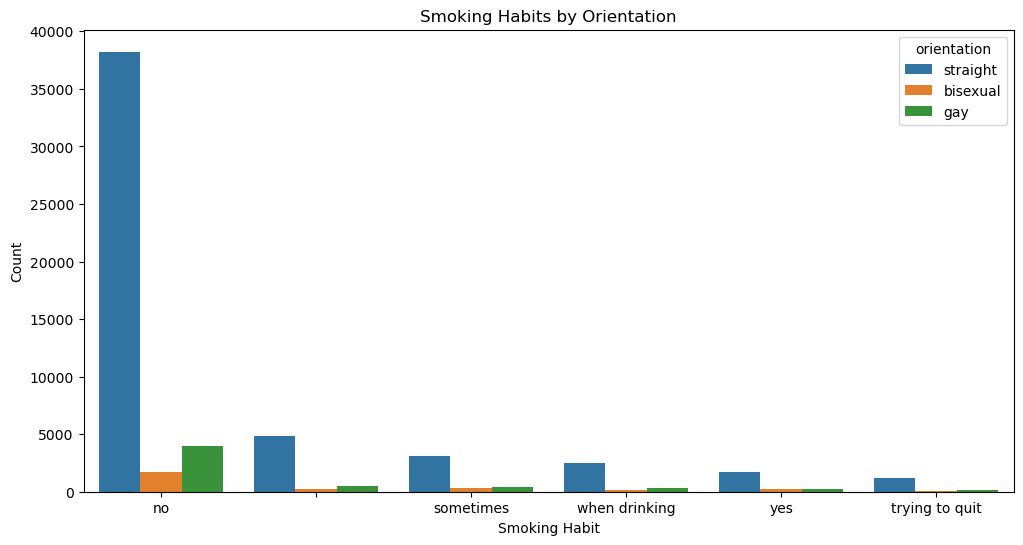

In [26]:

plt.figure(figsize=(8, 5))
sns.countplot(data=Cupid_file_cleaned, x='smokes', order=Cupid_file_cleaned['smokes'].value_counts().index)
plt.title('Distribution of Smoking Habits')
plt.xlabel('Smoking Habit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=Cupid_file_cleaned, x='smokes', hue='sex', order=Cupid_file_cleaned['smokes'].value_counts().index)
plt.title('Smoking Habits by Sex')
plt.xlabel('Smoking Habit')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=Cupid_file_cleaned, x='smokes', hue='orientation', order=Cupid_file_cleaned['smokes'].value_counts().index)
plt.title('Smoking Habits by Orientation')
plt.xlabel('Smoking Habit')
plt.ylabel('Count')
plt.show()



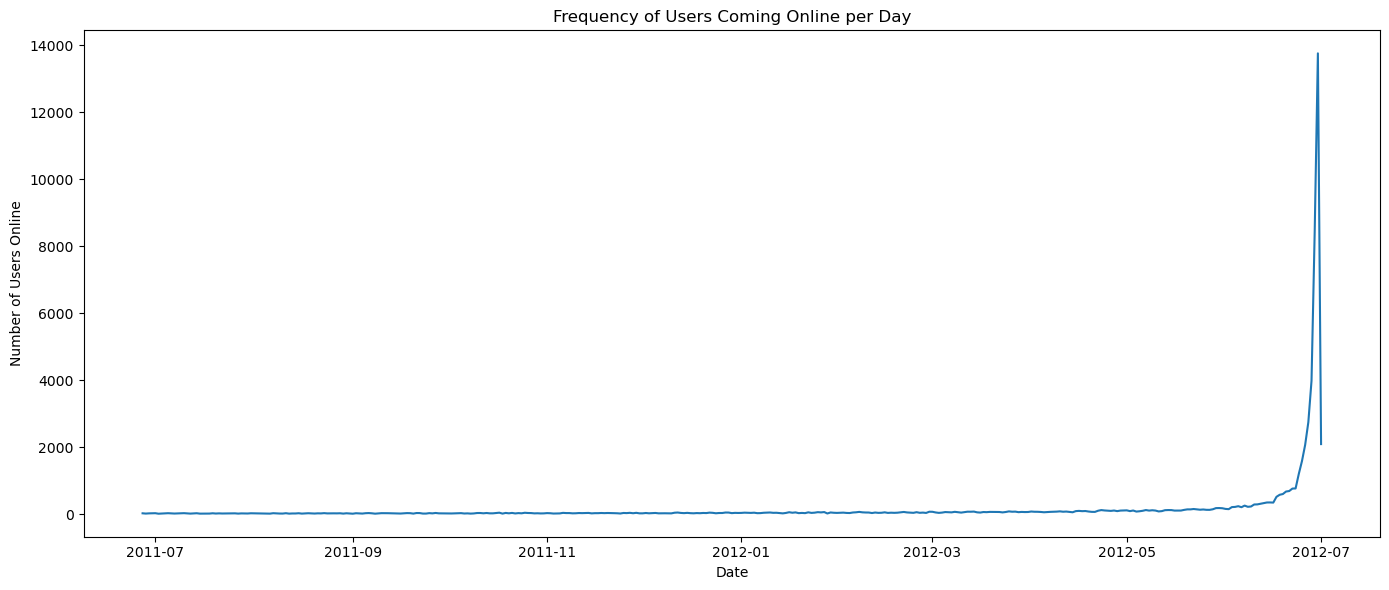

Top 10 most active days:
last_online_date
2012-06-30    13754
2012-06-29     8441
2012-06-28     3981
2012-06-27     2743
2012-07-01     2090
2012-06-26     2066
2012-06-25     1582
2012-06-24     1197
2012-06-23      766
2012-06-22      762
Name: count, dtype: int64


In [30]:
# Convert 'last_online' to datetime (strip timezone if present)
Cupid_file_cleaned['last_online_dt'] = pd.to_datetime(
	Cupid_file_cleaned['last_online'].str[:16],  # keep only 'YYYY-MM-DD-HH-MM'
	format='%Y-%m-%d-%H-%M',
	errors='coerce'
)

# Extract date part only
Cupid_file_cleaned['last_online_date'] = Cupid_file_cleaned['last_online_dt'].dt.date

# Count frequency of users coming online per day
online_freq = Cupid_file_cleaned['last_online_date'].value_counts().sort_index()

# Plot frequency
plt.figure(figsize=(14, 6))
online_freq.plot()
plt.title('Frequency of Users Coming Online per Day')
plt.xlabel('Date')
plt.ylabel('Number of Users Online')
plt.tight_layout()
plt.show()

# Show top 10 most active days
print("Top 10 most active days:")
print(online_freq.sort_values(ascending=False).head(10))

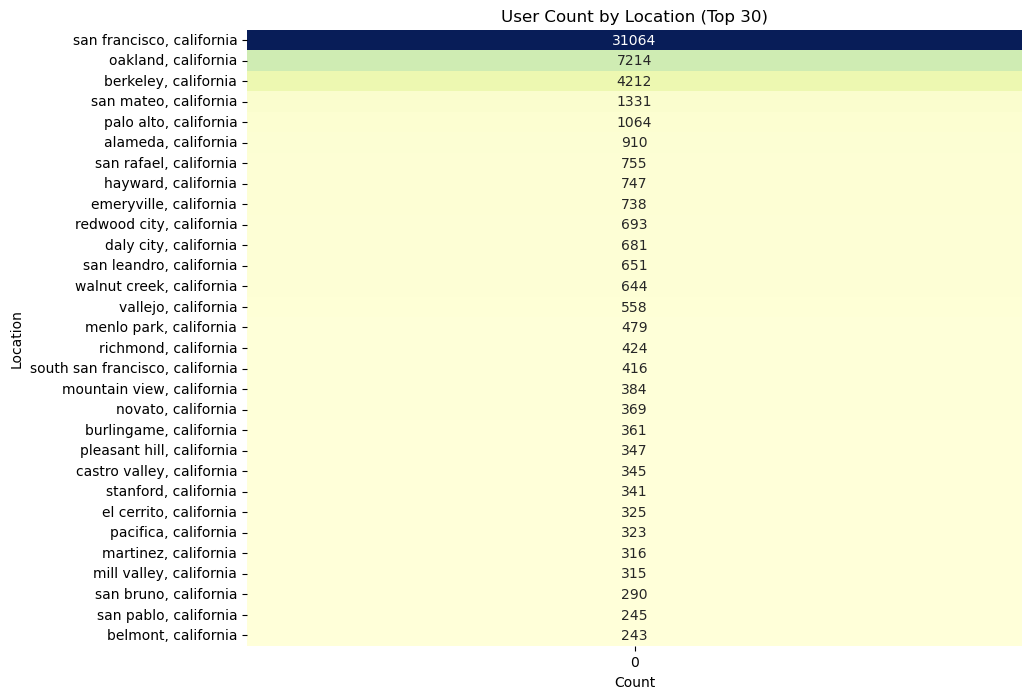

In [31]:
# Count occurrences of each location
location_counts = Cupid_file_cleaned['location'].value_counts().head(30)  # Top 30 locations for readability

plt.figure(figsize=(10, 8))
sns.heatmap(location_counts.values.reshape(-1, 1), annot=True, fmt='d',
            yticklabels=location_counts.index, cmap='YlGnBu', cbar=False)
plt.title('User Count by Location (Top 30)')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()